In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import logging
import copy
import yaml
import numpy as np
import matplotlib.pyplot as plt

from astropy import wcs
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.table import Table, Column, hstack
from mrf.utils import (save_to_fits, Flux_Model, extract_obj, \
                       bright_star_mask, Autokernel, psf_bkgsub)
from mrf.utils import seg_remove_obj, mask_out_certain_galaxy
from mrf.display import display_single, SEG_CMAP, display_multiple, draw_circles
from mrf.celestial import Celestial, Star

from reproject import reproject_interp

plt.rcParams['text.usetex'] = True

### Parameters of this task are stored in `default.yaml` file. Users could change that file accordingly.

In [2]:
# Load configuration file
from mrf.utils import Config
with open('m101-df3.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
    config = Config(cfg)
    
# Set logger
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.INFO, 
                    handlers=[logging.StreamHandler(sys.stdout)])
logger = logging.getLogger("")

## The following steps follow the descriptions in van Dokkum et al. PASP (2019) paper.

### 1. Subtract background of DF

In [3]:
df_image = config.file.df_image
hi_res_image_blue = config.file.hi_res_image_blue
hi_res_image_red = config.file.hi_res_image_red

hdu = fits.open(config.file.df_image)
df = Celestial(hdu[0].data, header=hdu[0].header)
if config.DF.sub_bkgval:
    logger.info('Subtract BACKVAL=%.1f of Dragonfly image', float(df.header['BACKVAL']))
    df.image -= float(df.header['BACKVAL'])
hdu.close()

### 2. Create magnified DF image, and register high-res images with subsampled DF ones (Sec 3.2)

In [4]:
f_magnify = config.DF.magnify_factor
resize_method = config.DF.resize_method
logger.info('Magnify Dragonfly image with a factor of {:.1f}'.format(f_magnify))
df.resize_image(f_magnify, method=resize_method);
df.save_to_fits('_df_{}.fits'.format(int(f_magnify)));


logger.info('Register high resolution image "{0}" with "{1}"'.format(hi_res_image_blue, df_image))
hdu = fits.open(hi_res_image_blue)
if 'hsc' in hi_res_image_blue:
    array, _ = reproject_interp(hdu[1], df.header)
else:
    array, _ = reproject_interp(hdu[0], df.header)
hires_b = Celestial(array, header=df.header)
hdu.close()


logger.info('Register high resolution image "{0}" with "{1}"'.format(hi_res_image_red, df_image))
hdu = fits.open(hi_res_image_red)
if 'hsc' in hi_res_image_red:
    array, _ = reproject_interp(hdu[1], df.header)
else:
    array, _ = reproject_interp(hdu[0], df.header)
hires_r = Celestial(array, header=df.header)
hdu.close()

2019-08-13 16:06:18,431 Magnify Dragonfly image with a factor of 3.0
2019-08-13 16:06:18,690 Register high resolution image "M101_DF3_cfht_r.fits" with "M101_DF3_df_r.fits"
2019-08-13 16:06:20,073 Register high resolution image "M101_DF3_cfht_r.fits" with "M101_DF3_df_r.fits"


### 3. Extract sources on hires images using SEP, which are used to make color correction (Sec 3.1)

In [5]:
sigma = config.sex.sigma
minarea = config.sex.minarea
b = config.sex.b
f = config.sex.f
deblend_cont = config.sex.deblend_cont
deblend_nthresh = config.sex.deblend_nthresh
sky_subtract = config.sex.sky_subtract
flux_aper = config.sex.flux_aper
show_fig = config.sex.show_fig

logger.info('Build flux models on high-resolution images: Blue band')
logger.info('    - sigma = %.1f, minarea = %d', sigma, minarea)
logger.info('    - deblend_cont = %.5f, deblend_nthres = %.1f', deblend_cont, deblend_nthresh)
_, _, b_imflux = Flux_Model(hires_b.image, hires_b.header, 
                            sigma=sigma, minarea=minarea, 
                            deblend_cont=deblend_cont, 
                            deblend_nthresh=deblend_nthresh, save=True)

logger.info('Build flux models on high-resolution images: Red band')
logger.info('    - sigma = %.1f, minarea = %d', sigma, minarea)
logger.info('    - deblend_cont = %.5f, deblend_nthres = %.1f', deblend_cont, deblend_nthresh)
_, _, r_imflux = Flux_Model(hires_r.image, hires_b.header, 
                            sigma=sigma, minarea=minarea, 
                            deblend_cont=deblend_cont, 
                            deblend_nthresh=deblend_nthresh, save=True)

2019-08-13 16:06:21,297 Build flux models on high-resolution images: Blue band
2019-08-13 16:06:21,298     - sigma = 2.5, minarea = 2
2019-08-13 16:06:21,298     - deblend_cont = 0.00500, deblend_nthres = 32.0
# Detect 8634 objects
2019-08-13 16:06:24,222 Build flux models on high-resolution images: Red band
2019-08-13 16:06:24,223     - sigma = 2.5, minarea = 2
2019-08-13 16:06:24,224     - deblend_cont = 0.00500, deblend_nthres = 32.0
# Detect 8634 objects


### 4. Make color correction, remove artifacts as well (Sec 3.1)

In [6]:
logger.info('Make color correction to blue band, remove artifacts as well')
col_ratio = (b_imflux / r_imflux)
col_ratio[np.isnan(col_ratio) | np.isinf(col_ratio)] = 0 # remove artifacts
save_to_fits(col_ratio, '_colratio.fits', header=hires_b.header)

color_term = config.DF.color_term
logger.info('    - color_term = {}'.format(color_term))
median_col = np.nanmedian(col_ratio[col_ratio != 0])
logger.info('    - median_color (blue/red) = {:.5f}'.format(median_col))

fluxratio = col_ratio / median_col
fluxratio[(fluxratio < 0.1) | (fluxratio > 10)] = 1 # remove extreme values
col_correct = np.power(fluxratio, color_term) # how to improve this correction?
save_to_fits(col_correct, '_colcorrect.fits', header=hires_b.header)

if config.DF.band == 'r':
    hires_3 = Celestial(hires_r.image * col_correct, header=hires_r.header)
elif config.DF.band == 'g':
    hires_3 = Celestial(hires_b.image * col_correct, header=hires_b.header)
else:
    raise ValueError('config.DF.band must be "g" or "r"!')

_ = hires_3.save_to_fits('_hires_{}.fits'.format(int(f_magnify)))

2019-08-13 16:06:27,281 Make color correction to blue band, remove artifacts as well
2019-08-13 16:06:27,346     - color_term = 0.0
2019-08-13 16:06:27,352     - median_color (blue/red) = 1.00000


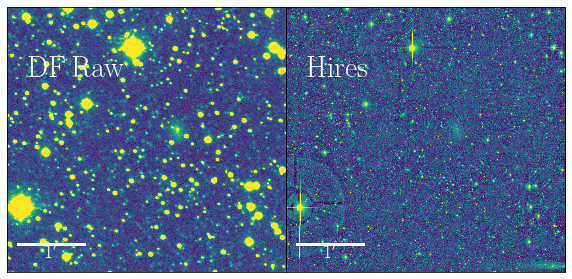

In [7]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
display_single(df.image, ax=ax1, 
               scale_bar_length=61, add_text='DF\,Raw', text_y_offset=0.7)
display_single(hires_3.image, ax=ax2, 
               scale_bar_length=61, add_text='Hires', text_y_offset=0.7)
plt.subplots_adjust(wspace=0)

### 5. Extract sources on hires corrected image (Sec 3.2)

In [8]:
logger.info('Extracting objects from color-corrected high resolution image with:')
logger.info('    - sigma = %.1f, minarea = %d', sigma, minarea)
logger.info('    - deblend_cont = %.5f, deblend_nthres = %.1f', deblend_cont, deblend_nthresh)
objects, segmap = extract_obj(hires_3.image, b=b, f=f, 
                              sigma=sigma, minarea=minarea, 
                              show_fig=False, flux_aper=flux_aper, 
                              deblend_nthresh=deblend_nthresh, 
                              deblend_cont=deblend_cont)

objects.write('_hires_obj_cat.fits', format='fits', overwrite=True)

2019-08-13 16:06:28,416 Extracting objects from color-corrected high resolution image with:
2019-08-13 16:06:28,417     - sigma = 2.5, minarea = 2
2019-08-13 16:06:28,418     - deblend_cont = 0.00500, deblend_nthres = 32.0
# Detect 8634 objects


### 6. Remove bright stars (and certain galaxies) (Sec 3.4). 
You can remove certain galaxies (stored in `config.file.certain_gal_cat`) from the flux model.

In [9]:
logger.info('Remove bright stars from this segmentation map, using SEP results. ')
logger.info('Bright star limit = {}'.format(config.star.bright_lim))
seg = copy.deepcopy(segmap)
mag = config.file.hi_res_zp - 2.5 * np.log10(abs(objects['flux']))
objects.add_column(Column(data=mag, name='mag'))
flag = np.where(mag < config.star.bright_lim)
for obj in objects[flag]:
    seg = seg_remove_obj(seg, obj['x'], obj['y'])

objects[flag].write('_bright_stars_3.fits', format='fits', overwrite=True)

# You can Mask out certain galaxy here.
logger.info('Remove objects from catalog {}'.format(config.file.certain_gal_cat))
gal_cat = Table.read(config.file.certain_gal_cat, format='ascii')
seg = mask_out_certain_galaxy(seg, hires_3.header, gal_cat=gal_cat)

2019-08-13 16:06:29,140 Remove bright stars from this segmentation map, using SEP results. 
2019-08-13 16:06:29,141 Bright star limit = 18.5
2019-08-13 16:06:29,313 Remove objects from catalog gal_cat_m101.txt
### Removing object 4773 from mask ###
### Removing object 0 from mask ###


### 7. Remove artifacts from `hires_3` by color ratio and then smooth the mask

2019-08-13 16:06:29,793 Flux model from high resolution image has been built!


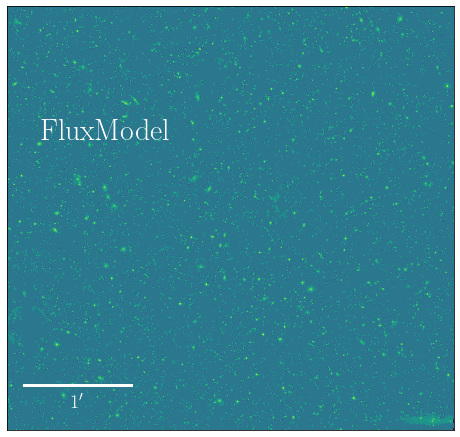

In [10]:
# Multiply by mask created from ratio of images - this removes all objects that are
# only in `g` or `r` but not in both (artifacts, transients, etc)
mask = seg * (col_ratio != 0)
mask[mask != 0] = 1

# Then blow mask up
from astropy.convolution import Gaussian2DKernel, Box2DKernel, convolve
smooth_radius = config.fluxmodel.gaussian_radius
mask_conv = copy.deepcopy(mask)
mask_conv[mask_conv > 0] = 1
mask_conv = convolve(mask_conv.astype(float), Gaussian2DKernel(smooth_radius))
seg_mask = (mask_conv >= config.fluxmodel.gaussian_threshold)

hires_fluxmod = Celestial(seg_mask * hires_3.image, header=hires_3.header)
hires_fluxmod.image[np.isnan(hires_fluxmod.image)] = 0
_ = hires_fluxmod.save_to_fits('_hires_fluxmod.fits')
logger.info('Flux model from high resolution image has been built!')

display_single(hires_fluxmod.image, scale='linear', scale_bar_length=61,
               add_text='FluxModel', text_y_offset=0.65);

### 8. Build kernel based on selected stars

2019-08-13 16:06:30,036 Build convolving kernel to degrade high resolution image.
# Detect 7961 objects
# Star 0: flux deviation = 0.031
# Star 1: flux deviation = 0.003
# Star 2: flux deviation = 0.013
# Star 3: flux deviation = 0.027
# Star 4: flux deviation = 0.030
# Star 5: flux deviation = 0.058
# Star 6: flux deviation = 0.012
# Star 7: flux deviation = 0.014
# Star 8: flux deviation = 0.022
# Star 9: flux deviation = 0.015
# Star 10: flux deviation = 0.022
# Star 11: flux deviation = 0.009
# Star 12: flux deviation = 0.012
# Star 13: flux deviation = 0.036
# Star 14: flux deviation = 0.060
# Star 15: flux deviation = 0.011
# Star 16: flux deviation = 0.051
# Star 17: flux deviation = 0.148
# Star 18: flux deviation = 0.124
# Star 19: flux deviation = 0.046
# Star 20: flux deviation = 0.067
# Star 21: flux deviation = 0.083
# Star 22: flux deviation = 0.096
# Star 23: flux deviation = 0.032
# Star 24: flux deviation = 0.044
You have 25 good stars to generate the median kernel


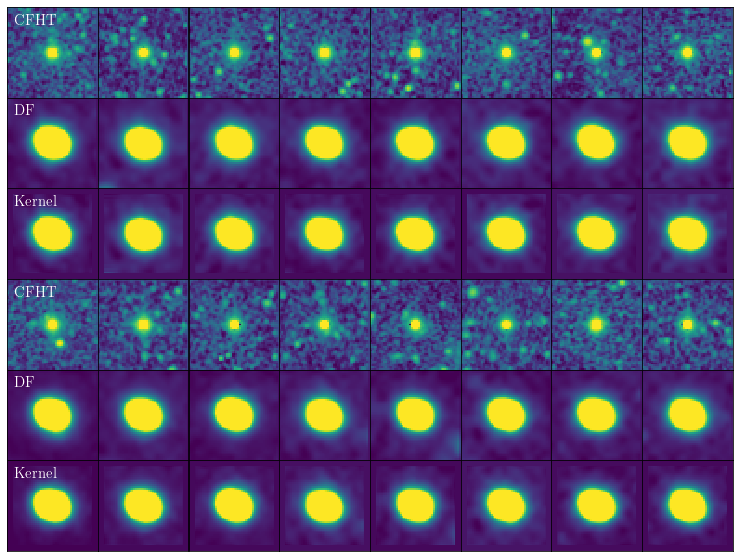

In [11]:
img_hires = Celestial(hires_3.image.byteswap().newbyteorder(), 
                      header=hires_3.header, dataset='cfht_3')
img_lowres = Celestial(df.image.byteswap().newbyteorder(), 
                       header=df.header, dataset='df_3')
cval = config.kernel.cval

if isinstance(cval, str) and 'nan' in cval.lower():
    cval = np.nan
else:
    cval = float(cval)

logger.info('Build convolving kernel to degrade high resolution image.')
kernel_med, good_cat = Autokernel(img_hires, img_lowres, 
                                  int(f_magnify * config.kernel.kernel_size), 
                                  int(f_magnify * (config.kernel.kernel_size - config.kernel.kernel_edge)), 
                                  frac_maxflux=config.kernel.frac_maxflux, 
                                  show_figure=config.kernel.show_fig, 
                                  cval=cval, nkernels=config.kernel.nkernel)
# You can also circularize the kernel
if config.kernel.circularize:
    logger.info('Circularize the kernel.')
    from compsub.utils import circularize
    kernel_med = circularize(kernel_med, n=14)
save_to_fits(kernel_med, 'kernel_median.fits');

### 9. Convolve kernel to high-res image (Sec 3.6)

In [12]:
# Two options: if you have `galsim` installed, use galsim, it's much faster. 
# Otherwise, use `fconvolve` from iraf.
# Galsim solution:
import galsim
psf = galsim.InterpolatedImage(galsim.Image(kernel_med), 
                               scale=config.DF.pixel_scale / f_magnify)
gal = galsim.InterpolatedImage(galsim.Image(hires_fluxmod.image), 
                               scale=config.DF.pixel_scale / f_magnify)
logger.info('Convolving image, this will be a bit slow @_@ ###')
final = galsim.Convolve([gal, psf])
image = final.drawImage(scale=config.DF.pixel_scale / f_magnify, 
                        nx=hires_3.shape[1], 
                        ny=hires_3.shape[0])
save_to_fits(image.array, '_df_model_{}.fits'.format(int(f_magnify)), header=hires_3.header)

# Optinally remove low surface brightness objects from model (Section 3.4)
if config.fluxmodel.unmask_lowsb:
    E = hires_fluxmod.image / image.array
    E[np.isinf(E) | np.isnan(E)] = 0.0

    kernel_flux = np.sum(kernel_med)
    print("# Kernel flux = {}".format(kernel_flux))
    E *= kernel_flux
    print('# Maximum of E = {}'.format(np.nanmax(E)))

    im_seg = copy.deepcopy(seg)
    im_highres = copy.deepcopy(hires_fluxmod.image)
    im_ratio = E
    im_highres_new =  np.zeros_like(hires_fluxmod.image)
    objects = Table.read('_hires_obj_cat.fits', format='fits')

    # calculate SB limit in counts per pixel
    sb_lim_cpp = 10**((config.fluxmodel.sb_lim - config.file.hi_res_zp)/(-2.5)) * (config.file.hi_res_pixelsize / f_magnify)**2
    print('# SB limit in counts / pixel = {}'.format(sb_lim_cpp))

    im_seg_ind = np.where(im_seg>0)
    im_seg_slice = im_seg[im_seg_ind]
    im_highres_slice = im_highres[im_seg_ind]
    im_highres_new_slice = im_highres_new[im_seg_ind]
    im_ratio_slice = im_ratio[im_seg_ind]

    # loop over objects
    for obj in objects:
        ind = np.where(np.isin(im_seg_slice, obj['index']))
        flux_hires = im_highres_slice[ind]
        flux_ratio = im_ratio_slice[ind]
        if ((np.mean(flux_hires) < sb_lim_cpp) and (np.mean(flux_ratio) < config.fluxmodel.unmask_ratio)) and (np.mean(flux_ratio) != 0):
            im_highres_new_slice[ind] = 1
            print('# removed object {}'.format(obj['index']))

    im_highres_new[im_seg_ind] = im_highres_new_slice
    save_to_fits(im_highres_new, '_hires_fluxmode_clean_mask.fits')

    # BLow up
    # Then blow mask up
    smooth_radius = config.fluxmodel.gaussian_radius
    mask_conv = copy.deepcopy(im_highres_new)
    mask_conv[mask_conv > 0] = 1
    mask_conv = convolve(mask_conv.astype(float), Gaussian2DKernel(smooth_radius))
    seg_mask = (mask_conv >= config.fluxmodel.gaussian_threshold)
    im_highres[seg_mask] = 0

    psf = galsim.InterpolatedImage(galsim.Image(kernel_med), 
                                scale=config.DF.pixel_scale / f_magnify)
    gal = galsim.InterpolatedImage(galsim.Image(im_highres), 
                                scale=config.DF.pixel_scale / f_magnify)
    logger.info('Convolving image, this will be a bit slow @_@ ###')
    final = galsim.Convolve([gal, psf])
    image = final.drawImage(scale=config.DF.pixel_scale / f_magnify, 
                            nx=hires_3.shape[1], 
                            ny=hires_3.shape[0])
    save_to_fits(image.array, '_df_model_clean_{}.fits'.format(f_magnify), header=hires_3.header)

df_model = Celestial(image.array, header=hires_3.header)
res = Celestial(df.image - df_model.image, header=df.header)
res.save_to_fits('_res_{}.fits'.format(f_magnify))

df.resize_image(1 / f_magnify, method=resize_method)

df_model.resize_image(1 / f_magnify, method=resize_method)
df_model.save_to_fits('_df_model.fits')

res.resize_image(1 / f_magnify, method=resize_method)
res.save_to_fits('res.fits')
logger.info('Compact objects has been subtracted from Dragonfly image! Saved as "res.fits".')


2019-08-13 16:06:46,262 Convolving image, this will be a bit slow @_@ ###
# Kernel flux = 0.00013369517779991967
# Maximum of E = 2080.3268311348465
# SB limit in counts / pixel = 3.8622765770891294
# removed object 22
# removed object 77
# removed object 137
# removed object 191
# removed object 193
# removed object 218
# removed object 277
# removed object 311
# removed object 468
# removed object 552
# removed object 595
# removed object 696
# removed object 704
# removed object 763
# removed object 768
# removed object 774
# removed object 825
# removed object 833
# removed object 892
# removed object 979
# removed object 1012
# removed object 1130
# removed object 1171
# removed object 1239
# removed object 1247
# removed object 1276
# removed object 1284
# removed object 1293
# removed object 1310
# removed object 1340
# removed object 1378
# removed object 1409
# removed object 1455
# removed object 1497
# removed object 1545
# removed object 1597
# removed object 1620
# removed

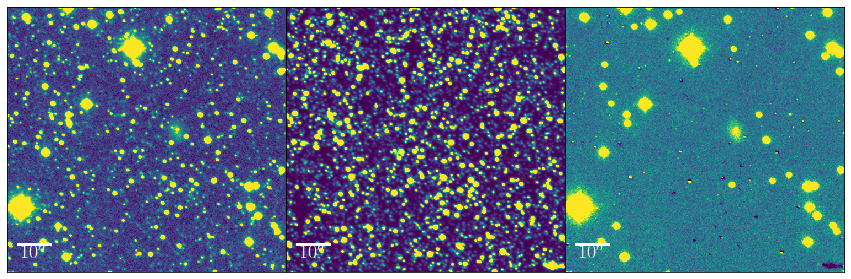

In [13]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 8))
ax1 = display_single(df.image, ax=ax1, scale_bar_length=10)
ax2 = display_single(df_model.image, ax=ax2, scale_bar_length=10)
ax3 = display_single(res.image, ax=ax3, scale_bar_length=10)
plt.subplots_adjust(wspace=0)

### 10. Subtract bright star halos! Only work with those left out in flux model! (Sec 3.7)

In [14]:
star_cat = Table.read('_bright_stars_3.fits', format='fits')
star_cat['x'] /= f_magnify
star_cat['y'] /= f_magnify
ra, dec = res.wcs.wcs_pix2world(star_cat['x'], star_cat['y'], 0)
star_cat.add_columns([Column(data=ra, name='ra'), Column(data=dec, name='dec')])

sigma = config.starhalo.sigma
minarea = config.starhalo.minarea
deblend_cont = config.starhalo.deblend_cont
deblend_nthresh = config.starhalo.deblend_nthresh
sky_subtract = config.starhalo.sky_subtract
flux_aper = config.starhalo.flux_aper
show_fig = config.starhalo.show_fig
logger.info('Extracting objects from compact-object-corrected Dragonfly image with:')
logger.info('    - sigma = %.1f, minarea = %d', sigma, minarea)
logger.info('    - deblend_cont = %.5f, deblend_nthres = %.1f', deblend_cont, deblend_nthresh)
objects, segmap = extract_obj(res.image.byteswap().newbyteorder(), 
                              b=64, f=3, sigma=3, minarea=minarea,
                              deblend_nthresh=deblend_nthresh, 
                              deblend_cont=deblend_cont, 
                              sky_subtract=sky_subtract, show_fig=show_fig, 
                              flux_aper=flux_aper)
ra, dec = res.wcs.wcs_pix2world(objects['x'], objects['y'], 0)
objects.add_columns([Column(data=ra, name='ra'), Column(data=dec, name='dec')])

# Match two catalogs
logger.info('Match detected objects with {} catalog to ensure they are stars.'.format(config.starhalo.method))
#temp = match_coordinates_sky(SkyCoord(ra=objects['ra'], dec=objects['dec'], unit='deg'),
#                             SkyCoord(ra=star_cat['ra'], dec=star_cat['dec'], unit='deg'))[0]
temp = match_coordinates_sky(SkyCoord(ra=star_cat['ra'], dec=star_cat['dec'], unit='deg'),
                             SkyCoord(ra=objects['ra'], dec=objects['dec'], unit='deg'))[0]
bright_star_cat = objects[np.unique(temp)]
mag = 20 - 2.5 * np.log10(bright_star_cat['flux'])
bright_star_cat.add_column(Column(data=mag, name='mag'))
bright_star_cat.write('_bright_star_cat.fits', format='fits', overwrite=True)

2019-08-13 16:07:17,045 Extracting objects from compact-object-corrected Dragonfly image with:
2019-08-13 16:07:17,045     - sigma = 4.0, minarea = 5
2019-08-13 16:07:17,046     - deblend_cont = 0.00500, deblend_nthres = 32.0
# Detect 89 objects
2019-08-13 16:07:17,073 Match detected objects with manual catalog to ensure they are stars.


In [15]:
# Extract stars from image
psf_cat = bright_star_cat[bright_star_cat['fwhm_custom'] < config.starhalo.fwhm_lim] # FWHM selection
psf_cat = psf_cat[psf_cat['mag'] < config.starhalo.bright_lim]
psf_cat.sort('flux')
psf_cat.reverse()
psf_cat = psf_cat[:int(config.starhalo.n_stack)]
logger.info('You get {} stars to be stacked!'.format(len(psf_cat)))

# Construct and stack `Stars`!!!.
halosize = config.starhalo.halosize
padsize = config.starhalo.padsize
size = 2 * halosize + 1
stack_set = np.zeros((len(psf_cat), size, size))
bad_indices = []
logger.info('Stacking stars!')
for i, obj in enumerate(psf_cat):
    try:
        sstar = Star(res.image, header=res.header, starobj=obj, 
                    halosize=halosize, padsize=padsize)
        if config.starhalo.mask_contam:
            sstar.mask_out_contam(show_fig=False, verbose=False)
        sstar.centralize(method='iraf')
        #sstar.sub_bkg(verbose=False)
        cval = config.starhalo.cval
        if isinstance(cval, str) and 'nan' in cval.lower():
            cval = np.nan
        else:
            cval = float(cval)

        if config.starhalo.norm == 'flux_ann':
            stack_set[i, :, :] = sstar.get_masked_image(cval=cval) / sstar.fluxann
        else:
            stack_set[i, :, :] = sstar.get_masked_image(cval=cval) / sstar.flux

    except Exception as e:
        stack_set[i, :, :] = np.ones((size, size)) * 1e9
        bad_indices.append(i)
        logger.info(e)

stack_set = np.delete(stack_set, bad_indices, axis=0)
median_psf = np.nanmedian(stack_set, axis=0)
median_psf = psf_bkgsub(median_psf, int(config.starhalo.edgesize))
from astropy.convolution import convolve, Box2DKernel
median_psf = convolve(median_psf, Box2DKernel(3))
save_to_fits(median_psf, 'median_psf.fits');
logger.info('Stars are stacked in to a PSF and saved as "median_psf.fits"!')
save_to_fits(stack_set, '_stack_bright_stars.fits')

## Build starhalo models and then subtract
logger.info('Draw star halo models onto the image, and subtract them!')

# Make an extra edge, move stars right
ny, nx = res.image.shape
im_padded = np.zeros((ny + 2 * halosize, nx + 2 * halosize))
# Making the left edge empty
im_padded[halosize: ny + halosize, halosize: nx + halosize] = res.image
im_halos_padded = np.zeros_like(im_padded)

for i, obj in enumerate(bright_star_cat):
    spsf = Celestial(median_psf, header=df_model.header)
    x = obj['x']
    y = obj['y']
    x_int = x.astype(np.int)
    y_int = y.astype(np.int)
    dx = -1.0 * (x - x_int)
    dy = -1.0 * (y - y_int)
    spsf.shift_image(-dx, -dy, method='iraf')
    x_int, y_int = x_int + halosize, y_int + halosize
    if config.starhalo.norm == 'flux_ann':
        im_halos_padded[y_int - halosize:y_int + halosize + 1, 
                        x_int - halosize:x_int + halosize + 1] += spsf.image * obj['flux_ann']
    else:
        im_halos_padded[y_int - halosize:y_int + halosize + 1, 
                        x_int - halosize:x_int + halosize + 1] += spsf.image * obj['flux']

im_halos = im_halos_padded[halosize: ny + halosize, halosize: nx + halosize]
img_sub = res.image - im_halos
df_model.image += im_halos

save_to_fits(im_halos, 'df_halos.fits', header=df_model.header)
save_to_fits(img_sub, 'df_halosub.fits', header=df_model.header)
save_to_fits(df_model.image, 'df_model_halos.fits', header=df_model.header)

logger.info('Bright star halos are subtracted! Saved as "df_halosub.fits".')

2019-08-13 16:07:18,067 You get 30 stars to be stacked!
2019-08-13 16:07:18,068 Stacking stars!
2019-08-13 16:07:22,175 Stars are stacked in to a PSF and saved as "median_psf.fits"!
2019-08-13 16:07:22,180 Draw star halo models onto the image, and subtract them!
2019-08-13 16:07:24,873 Bright star halos are subtracted! Saved as "df_halosub.fits".


### 11. Clean the image: mask out artifacts (Sec 3.8)

In [16]:
# Mask out dirty things!
if config.clean.clean_img:
    logger.info('Clean the image! Replace relics with noise.')
    model_mask = convolve(df_model.image, Gaussian2DKernel(config.clean.gaussian_radius))
    model_mask[model_mask < 0.005] = 0 # config.clean.gaussian_threshold
    model_mask[model_mask != 0] = 1
    totmask = bright_star_mask(model_mask.astype(bool), bright_star_cat, 
                                bright_lim=config.clean.bright_lim, r=13)#config.clean.r)

    # Total mask with noise
    totmask = convolve(totmask.astype(float), Box2DKernel(2))
    totmask[totmask > 0] = 1
    if config.clean.replace_with_noise:
        from compsub.utils import img_replace_with_noise
        final_image = img_replace_with_noise(res.image.byteswap().newbyteorder(), totmask)
    else:
        final_image = res.image * (~totmask.astype(bool))
    #save_to_fits(final_image, 'final_image.fits', header=res.header)
    logger.info('The final result is saved as "final_image.fits"!')


2019-08-13 16:07:24,898 Clean the image! Replace relics with noise.
2019-08-13 16:07:24,953 The final result is saved as "final_image.fits"!


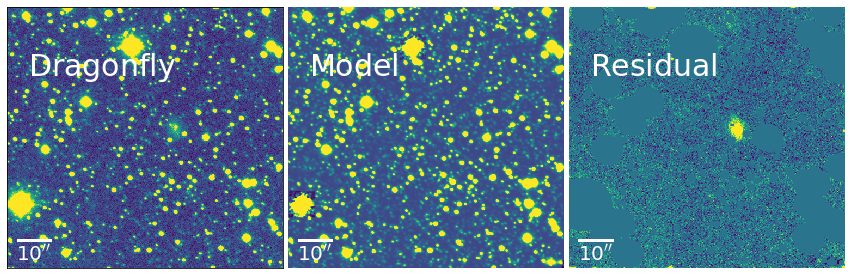

In [18]:
plt.rcParams['text.usetex'] = False
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 8))
df_image = fits.open(config.file.df_image)[0].data
ax1 = display_single(df_image, ax=ax1, scale_bar_length=10, scale_bar_y_offset=0.3,
                     add_text='Dragonfly', text_y_offset=0.7)
ax1 = display_single(df_model.image, ax=ax2, scale_bar_length=10, scale_bar_y_offset=0.3,
                     add_text='Model', text_y_offset=0.7)
ax3 = display_single(final_image, ax=ax3, scale_bar_length=10, scale_bar_y_offset=0.3,
                     add_text='Residual', text_y_offset=0.7)
for ax in [ax1, ax2, ax3]:
    ax.axis('off')
plt.subplots_adjust(wspace=0.02)
plt.savefig('mrf_result.png', bbox_inches='tight', facecolor='silver')

### 12. Delete temporary files 

In [170]:
# Delete temp files
if config.clean.clean_file:
    logger.info('Delete all temporary files!')
    os.system('rm -rf _*.fits')

logger.info('Mission finished!')

2019-08-13 15:40:31,696 Delete all temporary files!
2019-08-13 15:40:31,713 Mission finished!
